In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from util import *
from threading import Thread

species = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}

total = 1_160_526

In [20]:
# read in all data from the dataset.tsv and the paths given there
# read tree
tree = Tree("F:/Studium/Master/semester5/thesis/data/NCBI/taxdmp/tree_nr.txt")
true_taxons = get_true_taxons_for_all_ranks(tree, species)
# read in all results that have been generated so far
data = pd.read_csv("datasets_zymo_log.tsv", sep="\t", header=0).fillna("")
# define algorithms that should be included in the dataframe
algorithms = ["OVO (1.00) read count cumulative"]
for i, row in data.iterrows():
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(row.path, kmer_threshold=0, ovo_1_threshold=1)
    # filter for taxa that are known to be in the sample and sum up the (true) assigned reads per taxonomic rank
    per_taxon_assignment = per_taxon_assignment.loc[[label for labels in true_taxons.values() for label in labels if label in per_taxon_assignment.index]].groupby("rank").sum()
    # transform the data frame to have the taxonomic rank and algorithm as columns
    per_taxon_assignment = pd.melt(per_taxon_assignment.reset_index(), id_vars="rank", value_vars=algorithms, var_name="algorithm", value_name="true assigned reads")
    # add a column that combines the taxonomic rank and algorithm in one label
    per_taxon_assignment["rank, algorithm"] = per_taxon_assignment["rank"] + ", " + per_taxon_assignment["algorithm"]
    # add the true assigned reads per taxon-algorithm combination to the data frame
    data.loc[i, per_taxon_assignment["rank, algorithm"].values] = per_taxon_assignment["true assigned reads"].values
# save dataframe
data.to_csv("datasets_zymo_log_with_results.tsv", sep="\t", index=False)
data

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,"class, OVO (1.00) read count cumulative","family, OVO (1.00) read count cumulative","genus, OVO (1.00) read count cumulative","kingdom, OVO (1.00) read count cumulative","order, OVO (1.00) read count cumulative","phylum, OVO (1.00) read count cumulative","species, OVO (1.00) read count cumulative","superkingdom, OVO (1.00) read count cumulative"
0,kraken2 - NR,Solis 15 S,12,111111111111,15,segmasker,F:/Studium/Master/semester5/thesis/data/test_d...,,,1047614.0,1026844.0,949631.0,952270.0,1036442.0,1075198.0,745913.0,1135020.0
1,NR,DIAMOND,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,381.0,866265.0,786111.0,668883.0,1133327.0,799759.0,1025530.0,543596.0,1159378.0
2,NR,DIAMOND,15,11111101101100111000100001,26,,F:/Studium/Master/semester5/thesis/data/test_d...,,,747031.0,656350.0,558823.0,1105597.0,669227.0,947404.0,446301.0,1155014.0
3,NR,DIAMOND,15,11110010101011001101111,23,,F:/Studium/Master/semester5/thesis/data/test_d...,,,763076.0,666776.0,566183.0,1115401.0,679912.0,968371.0,451339.0,1157647.0
4,NR,DIAMOND,15,111111111111111,15,p < 1e-12,F:/Studium/Master/semester5/thesis/data/test_d...,,,889998.0,838537.0,708133.0,1119899.0,851859.0,1000570.0,572982.0,1155323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,NR90,uniform 11 S,11,11111111111,11,,F:/Studium/Master/semester5/thesis/data/test_d...,,238.0,938175.0,841203.0,738044.0,1134332.0,860255.0,1061123.0,440848.0,1156610.0
59,NR90,uniform 11 S,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,292.0,977658.0,954478.0,822257.0,1022066.0,966040.0,991028.0,465875.0,1049089.0
60,NR90,uniform 11 S,12,111010110100110111,18,,F:/Studium/Master/semester5/thesis/data/test_d...,,271.0,9749.0,2984.0,1287.0,62918.0,5033.0,33213.0,106.0,101551.0
61,NR90,uniform 11 S,12,11111100111111,14,,F:/Studium/Master/semester5/thesis/data/test_d...,,269.0,979100.0,940880.0,821375.0,1101542.0,955293.0,1033555.0,480641.0,1144182.0


In [12]:
# read in only the new data
# read tree
tree = Tree("F:/Studium/Master/semester5/thesis/data/NCBI/taxdmp/tree_nr.txt")
true_taxons = get_true_taxons_for_all_ranks(tree, species)
# read in all results that have been generated so far
data = pd.read_csv("datasets_zymo_log.tsv", sep="\t", header=0).fillna("")
# read in existing data:
data_processed = pd.read_csv("datasets_zymo_log_with_results.tsv", sep="\t", header=0).fillna("")
# define algorithms that should be included in the dataframe
algorithms = ["OVO (1.00) read count cumulative"]
for i, row in data.iterrows():
    # check if the row is already in the processed data
    if row.path in data_processed.path.values:
        continue
    else:
        # add the row to the processed data
        data_processed = pd.concat([data_processed, row.to_frame().T], ignore_index=True)

    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(row.path, kmer_threshold=0, ovo_1_threshold=1)
    # filter for taxa that are known to be in the sample and sum up the (true) assigned reads per taxonomic rank
    per_taxon_assignment = per_taxon_assignment.loc[[label for labels in true_taxons.values() for label in labels if label in per_taxon_assignment.index]].groupby("rank").sum()
    # transform the data frame to have the taxonomic rank and algorithm as columns
    per_taxon_assignment = pd.melt(per_taxon_assignment.reset_index(), id_vars="rank", value_vars=algorithms, var_name="algorithm", value_name="true assigned reads")
    # add a column that combines the taxonomic rank and algorithm in one label
    per_taxon_assignment["rank, algorithm"] = per_taxon_assignment["rank"] + ", " + per_taxon_assignment["algorithm"]
    # add the true assigned reads per taxon-algorithm combination to the data frame
    data_processed.loc[len(data_processed) - 1, per_taxon_assignment["rank, algorithm"].values] = per_taxon_assignment["true assigned reads"].values
data = data_processed
# save dataframe
data.to_csv("datasets_zymo_log_with_results.tsv", sep="\t", index=False)
data

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,"class, OVO (1.00) read count cumulative","family, OVO (1.00) read count cumulative","genus, OVO (1.00) read count cumulative","kingdom, OVO (1.00) read count cumulative","order, OVO (1.00) read count cumulative","phylum, OVO (1.00) read count cumulative","species, OVO (1.00) read count cumulative","superkingdom, OVO (1.00) read count cumulative"
0,kraken2 - NR,Solis 15 S,12,111111111111,15,segmasker,F:/Studium/Master/semester5/thesis/data/test_d...,,,1047614.0,1026844.0,949631.0,952270.0,1036442.0,1075198.0,745913.0,1135020.0
1,NR,DIAMOND,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,381.0,866265.0,786111.0,668883.0,1133327.0,799759.0,1025530.0,543596.0,1159378.0
2,NR,DIAMOND,15,11111101101100111000100001,26,,F:/Studium/Master/semester5/thesis/data/test_d...,,,747031.0,656350.0,558823.0,1105597.0,669227.0,947404.0,446301.0,1155014.0
3,NR,DIAMOND,15,11110010101011001101111,23,,F:/Studium/Master/semester5/thesis/data/test_d...,,,763076.0,666776.0,566183.0,1115401.0,679912.0,968371.0,451339.0,1157647.0
4,NR,DIAMOND,15,111111111111111,15,p < 1e-12,F:/Studium/Master/semester5/thesis/data/test_d...,,,889998.0,838537.0,708133.0,1119899.0,851859.0,1000570.0,572982.0,1155323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,complexity,128.0,1006255.0,985946.0,863404.0,1079929.0,996109.0,1031963.0,715132.0,1120223.0
65,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,complexity - only DB,128.0,1006255.0,985946.0,863404.0,1079929.0,996109.0,1031963.0,715132.0,1120223.0
66,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,probability,184.0,1023922.0,1004679.0,880553.0,1094506.0,1014324.0,1048592.0,730899.0,1129549.0
67,NR,uniform 11 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,old,611.0,1045211.0,1029111.0,906952.0,1110716.0,1037784.0,1067409.0,754696.0,1138422.0


C:\Users\nk035\AppData\Local\Temp\ipykernel_27252\3308915469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_all_nr["label"] = select_all_nr["alphabet"] + " " + select_all_nr["kmer size"].astype(str) + " " + select_all_nr["minimizer window"].astype(str) + " " + select_all_nr["minimizer criterion"] + " " + select_all_nr["filtering"]


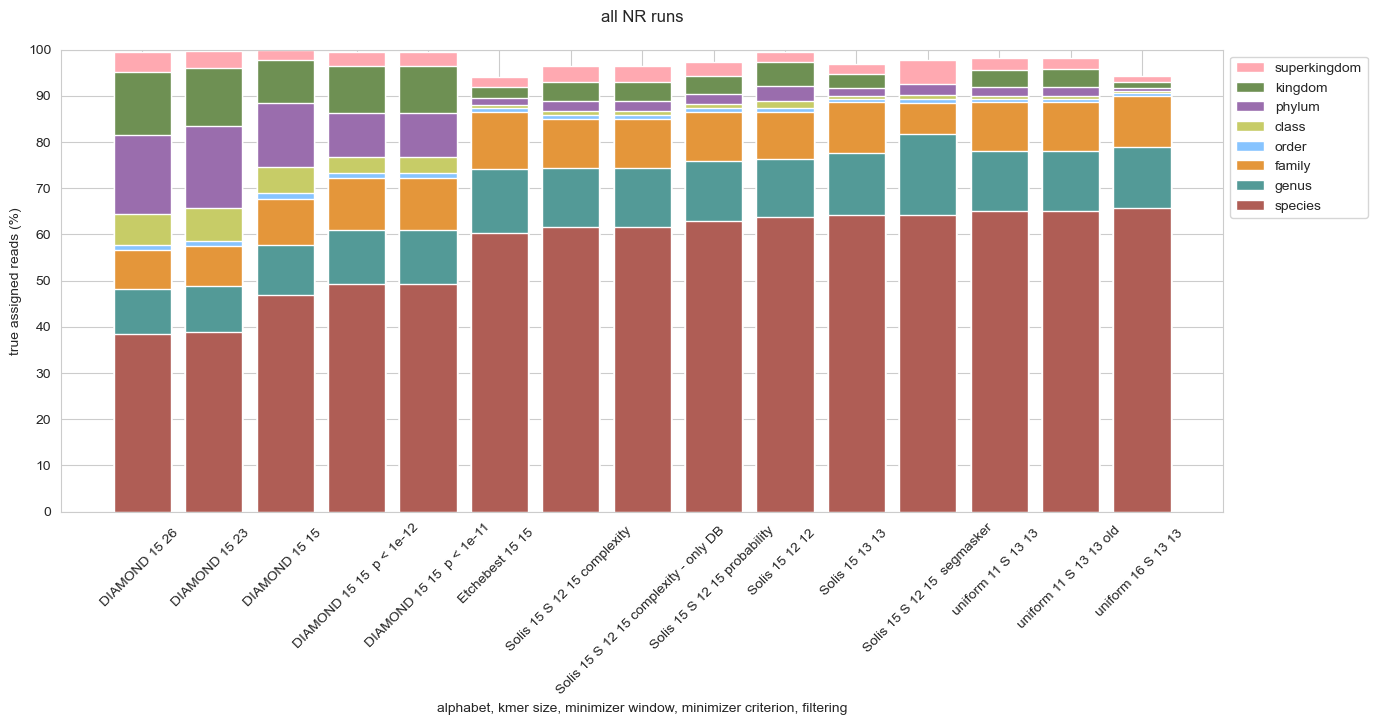

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,class,family,genus,kingdom,order,phylum,species,superkingdom,label
2,NR,DIAMOND,15,11111101101100111000100001,26,,F:/Studium/Master/semester5/thesis/data/test_d...,,,747031.0,656350.0,558823.0,1105597.0,669227.0,947404.0,446301.0,1155014.0,DIAMOND 15 26
3,NR,DIAMOND,15,11110010101011001101111,23,,F:/Studium/Master/semester5/thesis/data/test_d...,,,763076.0,666776.0,566183.0,1115401.0,679912.0,968371.0,451339.0,1157647.0,DIAMOND 15 23
1,NR,DIAMOND,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,381.0,866265.0,786111.0,668883.0,1133327.0,799759.0,1025530.0,543596.0,1159378.0,DIAMOND 15 15
4,NR,DIAMOND,15,111111111111111,15,p < 1e-12,F:/Studium/Master/semester5/thesis/data/test_d...,,,889998.0,838537.0,708133.0,1119899.0,851859.0,1000570.0,572982.0,1155323.0,DIAMOND 15 15 p < 1e-12
5,NR,DIAMOND,15,111111111111111,15,p < 1e-11,F:/Studium/Master/semester5/thesis/data/test_d...,,347.0,889998.0,838537.0,708133.0,1119899.0,851859.0,1000570.0,572982.0,1155323.0,DIAMOND 15 15 p < 1e-11
6,NR,Etchebest,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,581.0,1021738.0,1003456.0,859970.0,1066306.0,1014783.0,1038946.0,699845.0,1092230.0,Etchebest 15 15
64,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,complexity,128.0,1006255.0,985946.0,863404.0,1079929.0,996109.0,1031963.0,715132.0,1120223.0,Solis 15 S 12 15 complexity
65,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,complexity - only DB,128.0,1006255.0,985946.0,863404.0,1079929.0,996109.0,1031963.0,715132.0,1120223.0,Solis 15 S 12 15 complexity - only DB
66,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,probability,184.0,1023922.0,1004679.0,880553.0,1094506.0,1014324.0,1048592.0,730899.0,1129549.0,Solis 15 S 12 15 probability
7,NR,Solis 15,12,111111111111,12,,F:/Studium/Master/semester5/thesis/data/test_d...,,539.0,1031226.0,1003328.0,885799.0,1129774.0,1012979.0,1070019.0,739949.0,1154170.0,Solis 15 12 12


In [13]:
# all NR runs
select_all_nr = data.loc[((data["database"] == "NR") | (data["database"] == "kraken2 - NR"))]
select_all_nr["label"] = select_all_nr["alphabet"] + " " + select_all_nr["kmer size"].astype(str) + " " + select_all_nr["minimizer window"].astype(str) + " " + select_all_nr["minimizer criterion"] + " " + select_all_nr["filtering"]
select_all_nr = select_all_nr.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_all_nr, total, "all NR runs", "alphabet, kmer size, minimizer window, minimizer criterion, filtering")
select_all_nr

C:\Users\nk035\AppData\Local\Temp\ipykernel_27252\3921702116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_different_filtering_nr90["label"] = select_different_filtering_nr90["filtering"]


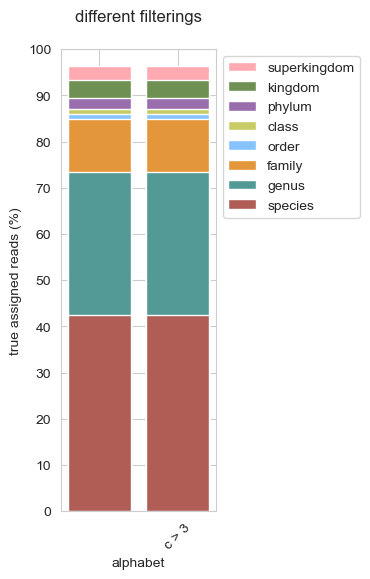

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,class,family,genus,kingdom,order,phylum,species,superkingdom,label
64,NR90,uniform 11 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,171.0,1010993.0,984418.0,852756.0,1083364.0,997887.0,1036878.0,493831.0,1119338.0,
63,NR90,uniform 11 S,13,1111111111111,13,c > 3,F:/Studium/Master/semester5/thesis/data/test_d...,,279.0,1011460.0,984836.0,853055.0,1083842.0,998321.0,1037336.0,493938.0,1119180.0,c > 3


In [3]:
# filtering nr90 uniform 11 S k = 13
select_different_filtering_nr90 = data.loc[(data["database"] == "NR90") & (data["kmer size"] == 13) & (data["alphabet"] == "uniform 11 S")]
select_different_filtering_nr90["label"] = select_different_filtering_nr90["filtering"]
select_different_filtering_nr90 = select_different_filtering_nr90.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_different_filtering_nr90, total, "different filterings", "alphabet")
select_different_filtering_nr90

C:\Users\nk035\AppData\Local\Temp\ipykernel_24964\1598766374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_kraken2_vs_diamer2["label"] = select_kraken2_vs_diamer2["database"] + ", " + select_kraken2_vs_diamer2["alphabet"] + ", " + select_kraken2_vs_diamer2["kmer size"].astype(str)


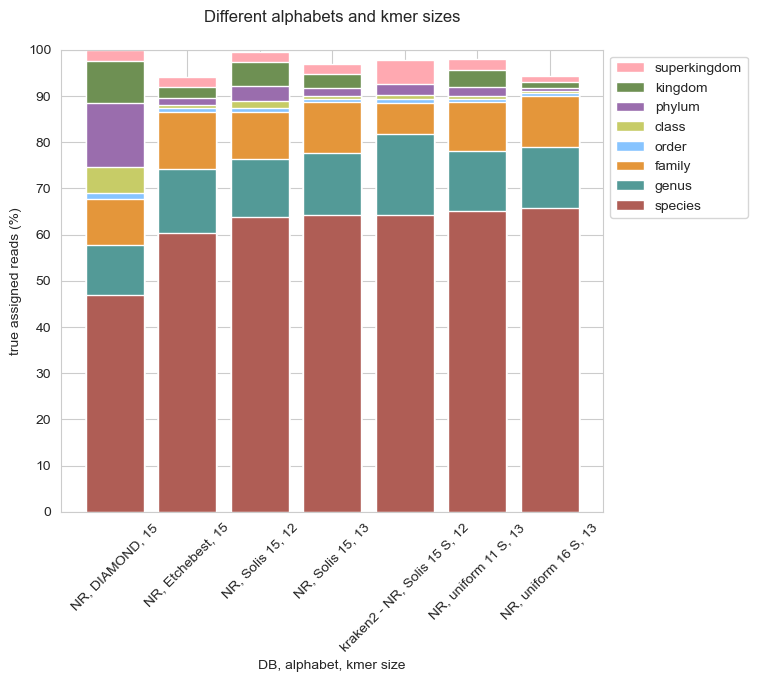

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,class,family,genus,kingdom,order,phylum,species,superkingdom,label
1,NR,DIAMOND,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,381.0,866265.0,786111.0,668883.0,1133327.0,799759.0,1025530.0,543596.0,1159378.0,"NR, DIAMOND, 15"
6,NR,Etchebest,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,581.0,1021738.0,1003456.0,859970.0,1066306.0,1014783.0,1038946.0,699845.0,1092230.0,"NR, Etchebest, 15"
7,NR,Solis 15,12,111111111111,12,,F:/Studium/Master/semester5/thesis/data/test_d...,,539.0,1031226.0,1003328.0,885799.0,1129774.0,1012979.0,1070019.0,739949.0,1154170.0,"NR, Solis 15, 12"
8,NR,Solis 15,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,581.0,1045361.0,1028030.0,900512.0,1099738.0,1037710.0,1065131.0,745217.0,1125507.0,"NR, Solis 15, 13"
0,kraken2 - NR,Solis 15 S,12,111111111111,15,segmasker,F:/Studium/Master/semester5/thesis/data/test_d...,,,1047614.0,1026844.0,949631.0,952270.0,1036442.0,1075198.0,745913.0,1135020.0,"kraken2 - NR, Solis 15 S, 12"
63,NR,uniform 11 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,611.0,1045211.0,1029111.0,906952.0,1110716.0,1037784.0,1067409.0,754696.0,1138422.0,"NR, uniform 11 S, 13"
9,NR,uniform 16 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,629.0,1056007.0,1043217.0,916819.0,1080194.0,1051395.0,1064676.0,761947.0,1095474.0,"NR, uniform 16 S, 13"


In [4]:
# kraken2 vs diamer2
select_kraken2_vs_diamer2 = data.loc[((data["database"] == "kraken2 - NR") | (data["database"] == "NR")) & ((data["filtering"] == "") | (data["filtering"] == "segmasker")) & ~(data["seed shape"].str.contains("0"))]
select_kraken2_vs_diamer2["label"] = select_kraken2_vs_diamer2["database"] + ", " + select_kraken2_vs_diamer2["alphabet"] + ", " + select_kraken2_vs_diamer2["kmer size"].astype(str)
select_kraken2_vs_diamer2 = select_kraken2_vs_diamer2.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_kraken2_vs_diamer2, total, "Different alphabets and kmer sizes", "DB, alphabet, kmer size")
select_kraken2_vs_diamer2

C:\Users\nk035\AppData\Local\Temp\ipykernel_24964\4096389559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_seed_shapes_nr90_uniform["label"] = select_seed_shapes_nr90_uniform["kmer size"].astype(str) + ", " + select_seed_shapes_nr90_uniform["minimizer window"].astype(str)


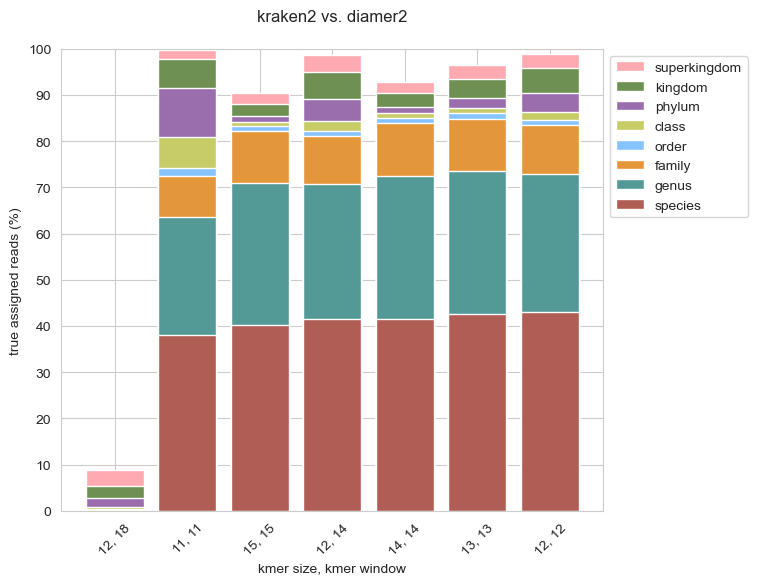

In [5]:
# different seed shapes uniform11 s
select_seed_shapes_nr90_uniform = data.loc[(data["database"] == "NR90") & (data["filtering"] == "") & (data["minimizer criterion"] == "") & (data["alphabet"] == "uniform 11 S")]
select_seed_shapes_nr90_uniform["label"] = select_seed_shapes_nr90_uniform["kmer size"].astype(str) + ", " + select_seed_shapes_nr90_uniform["minimizer window"].astype(str)
select_seed_shapes_nr90_uniform = select_seed_shapes_nr90_uniform.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_seed_shapes_nr90_uniform, total, "kraken2 vs. diamer2", "kmer size, kmer window")

C:\Users\nk035\AppData\Local\Temp\ipykernel_24964\4224792497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_kmer_sizes_nr90_uniform["label"] = select_kmer_sizes_nr90_uniform["kmer size"]


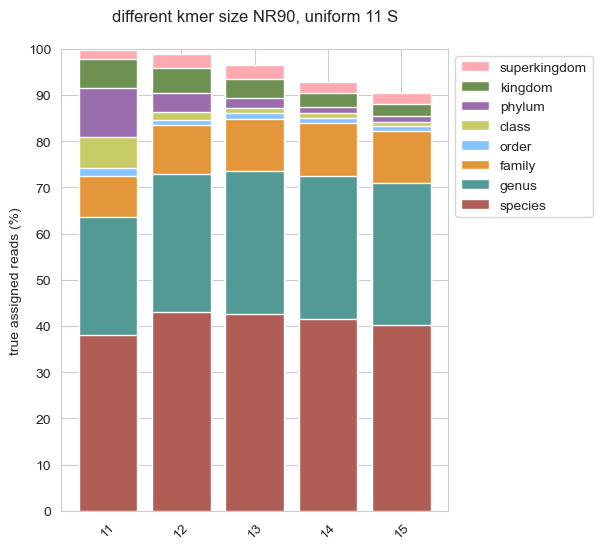

In [6]:
# kmer sizes uniform11s
select_kmer_sizes_nr90_uniform = data.loc[(data["database"] == "NR90") & (data["filtering"] == "") & (data["alphabet"] == "uniform 11 S") & (data["kmer size"] == data["minimizer window"])]
select_kmer_sizes_nr90_uniform["label"] = select_kmer_sizes_nr90_uniform["kmer size"]
select_kmer_sizes_nr90_uniform = select_kmer_sizes_nr90_uniform.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["label"])
plot_true_assigned_per_rank(select_kmer_sizes_nr90_uniform, total, "different kmer size NR90, uniform 11 S")

C:\Users\nk035\AppData\Local\Temp\ipykernel_24964\1487159581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_complexity_maximizer_nr90["label"] = select_complexity_maximizer_nr90["minimizer window"]


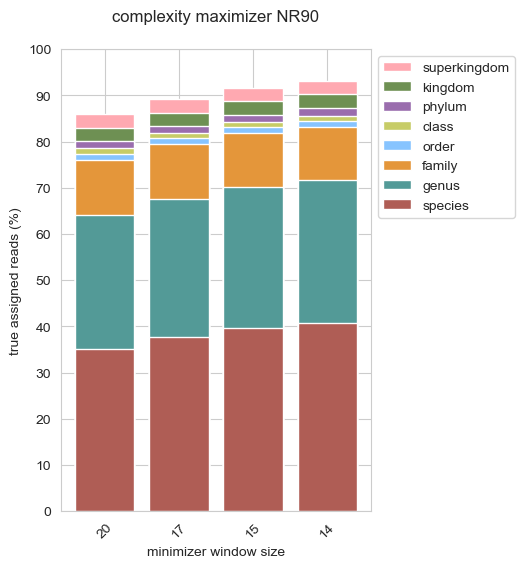

In [7]:
# complexity maximizer nr90, k=13, solis15
select_complexity_maximizer_nr90 = data.loc[(data["database"] == "NR90") & (data["kmer size"] == 13) & (data["filtering"] == "") & (data["minimizer criterion"] == "complexity")]
select_complexity_maximizer_nr90["label"] = select_complexity_maximizer_nr90["minimizer window"]
select_complexity_maximizer_nr90 = select_complexity_maximizer_nr90.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative",""))
plot_true_assigned_per_rank(select_complexity_maximizer_nr90, total, "complexity maximizer NR90", "minimizer window size")

C:\Users\nk035\AppData\Local\Temp\ipykernel_24964\4206436002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_different_alphabets_nr90["label"] = select_different_alphabets_nr90["alphabet"]


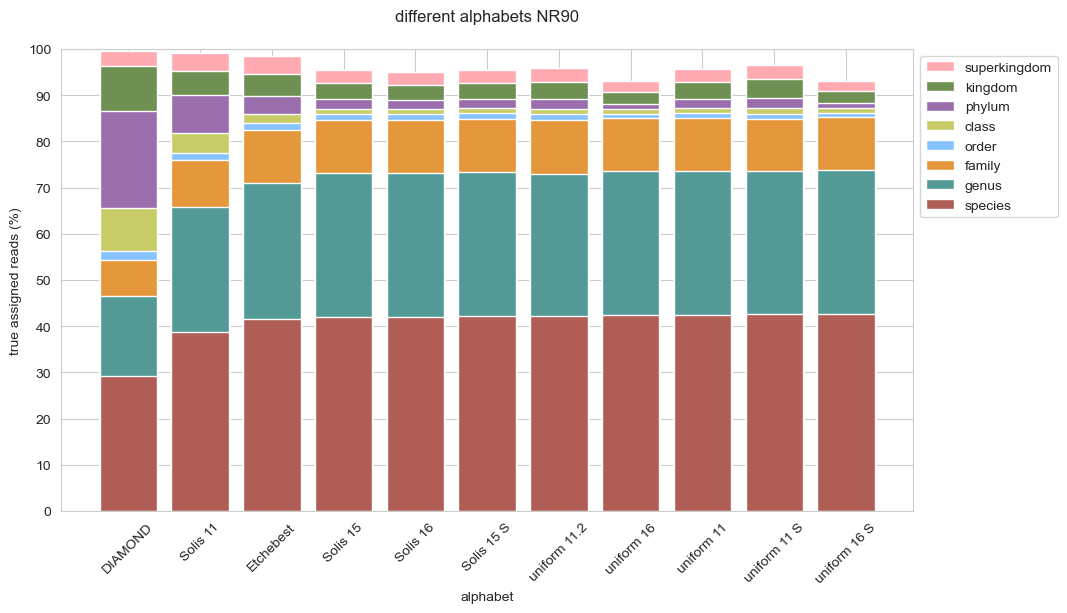

In [8]:
# different alphabets
select_different_alphabets_nr90 = data.loc[(data["database"] == "NR90") & (data["kmer size"] == 13) & (data["filtering"] == "") & (data["minimizer criterion"] == "")]
select_different_alphabets_nr90["label"] = select_different_alphabets_nr90["alphabet"]
select_different_alphabets_nr90 = select_different_alphabets_nr90.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_different_alphabets_nr90, total, "different alphabets NR90", "alphabet")

C:\Users\nk035\AppData\Local\Temp\ipykernel_24964\2782156192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_kmer_sizes_nr90["label"] = select_kmer_sizes_nr90["kmer size"]


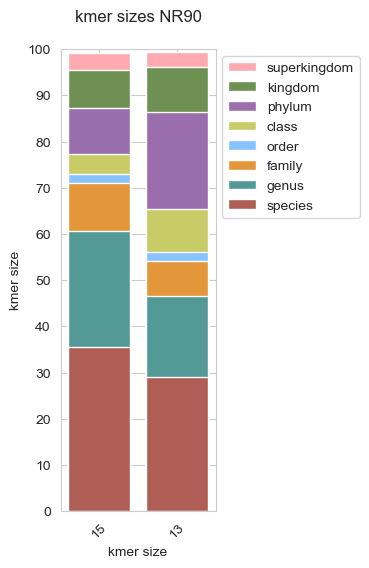

In [9]:
# kmer sizes diamond
select_kmer_sizes_nr90 = data.loc[(data["database"] == "NR90") & (data["filtering"] == "") & (data["minimizer criterion"] == "") & (data["alphabet"] == "DIAMOND") & (data["kmer size"] == data["minimizer window"])]
select_kmer_sizes_nr90["label"] = select_kmer_sizes_nr90["kmer size"]
select_kmer_sizes_nr90 = select_kmer_sizes_nr90.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative",""))
plot_true_assigned_per_rank(select_kmer_sizes_nr90, total, "kmer sizes NR90", "kmer size", "kmer size")

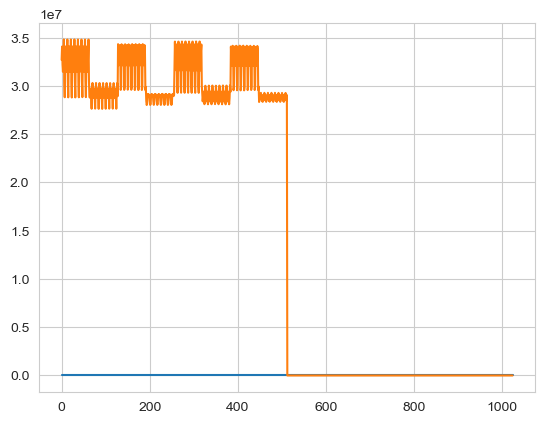

In [8]:
bucket_sizes = pd.read_csv("bucket_sizes_index_nr90_diamond_13-mer.tsv", sep="\t", header=None)
plt.plot(bucket_sizes)

In [9]:
select_alphabets = ["NR kraken2 protein", "NR90 DIAMOND", "NR90 Etchebest", "NR90 uniform", "NR90 Solis11", "NR90 Solis15 (13-mer)", "NR90 all 20 (12-mer)", "NR DIAMOND", "NR Etchebest"]
select_alphabets_nr90 = ["NR90 all 20 (12-mer)", "NR90 DIAMOND", "NR90 Solis11", "NR90 uniform", "NR90 Etchebest", "NR90 Solis15 (13-mer)", "NR90 Solis15 (12-mer)"]
select_alphabets_nr = ["NR DIAMOND", "NR Etchebest", "NR Solis15 (13-mer)", "NR kraken2 protein", "NR Solis15 (12-mer)"]
select_filtering_nr90_solis15_12_mer = ["NR90 Solis15 (12-mer)", "NR90 Solis15 (12-mer, l=15)", "NR90 Solis15 (12-mer, p<1e-12)", "NR90 Solis15 (12-mer, c>3)"]
select_filtering_nr90_diamond = ["NR90 DIAMOND", "NR90 DIAMOND (c>4)", "NR90 DIAMOND (c>5)", "NR90 DIAMOND (p<1e-9)", "NR90 DIAMOND (p<1e-10)", "NR90 DIAMOND (p<1e-11)", "NR90 DIAMOND (p<1e-12)", "NR90 DIAMOND (p<1e-13)", "NR90 DIAMOND (p<1e-11, c>3)", "NR90 DIAMOND (segmasker)"]
select_filtering_nr90_solis15 = ["NR90 Solis15 (12-mer)", "NR90 Solis15 (12-mer, l=15)", "NR90 Solis15 (13-mer)", "NR90 Solis15 (13-mer, l=15)", "NR90 Solis15 (13-mer, probability, l=15)", "NR90 Solis15 (13-mer, probability, l=17)", "NR90 Solis15 (13-mer, probability, l=20)", "NR90 Solis15 (13-mer, probability, l=27)", "NR90 Solis15 (13-mer, complexity, l=14)", "NR90 Solis15 (13-mer, complexity, l=15)", "NR90 Solis15 (13-mer, complexity, l=17)", "NR90 Solis15 (13-mer, complexity, l=20)"]
select_filtering_probability_nr90_diamond = ["NR90 DIAMOND", "NR90 DIAMOND (p<1e-9)", "NR90 DIAMOND (p<1e-10)", "NR90 DIAMOND (p<1e-11)", "NR90 DIAMOND (p<1e-12)", "NR90 DIAMOND (p<1e-13)"]
select_filtering_complexity_nr90_diamond = ["NR90 DIAMOND", "NR90 DIAMOND (c>4)", "NR90 DIAMOND (c>5)", "NR90 DIAMOND (segmasker)"]
select_filtering_nr90_etchebest = ["NR90 Etchebest", "NR90 Etchebest (c>4)", "NR90 Etchebest (p<1e-11)", "NR90 Etchebest (p<1e-12)", "NR90 Etchebest (p<1e-13)"]
select_best_filtering = ["NR90 DIAMOND", "NR90 DIAMOND (c>4)", "NR90 DIAMOND (p<1e-11)", "NR DIAMOND", "NR DIAMOND (p<1e-11)"]
select_filtering_nr = ["NR Etchebest", "NR Solis15 (13-mer)", "NR Solis15 (12-mer)", "NR kraken2 protein", "NR kraken2 protein", "NR DIAMOND", "NR DIAMOND (p<1e-11)", "NR DIAMOND (p<1e-12)"]
select_spaced_seeds = ["NR90 DIAMOND", "NR90 DIAMOND (seed 1)", "NR90 DIAMOND (seed 2)", "NR90 Etchebest", "NR90 Etchebest (seed 1)", "NR90 Etchebest (seed 2)", "NR90 uniform", "NR90 uniform (seed 1)", "NR DIAMOND", "NR DIAMOND (seed 1)", "NR DIAMOND (seed 2)"]
select_spaced_seeds_nr90_diamond = ["NR90 DIAMOND", "NR90 DIAMOND (seed 1)", "NR90 DIAMOND (seed 2)"]
select_spaced_seeds_nr90_etchebest = ["NR90 Etchebest", "NR90 Etchebest (seed 1)", "NR90 Etchebest (seed 2)"]
select_spaced_seeds_nr_diamond = ["NR DIAMOND", "NR DIAMOND (seed 1)", "NR DIAMOND (seed 2)"]

In [8]:
# read tree
tree = Tree("F:/Studium/Master/semester5/thesis/data/NCBI/taxdmp/tree_nr.txt")
true_taxons = get_true_taxons_for_all_ranks(tree, species)
# read per taxon assignments
# taxon_assignments_and_names = [(read_per_taxon_assignment(path, kmer_threshold=1000), name) for path, name in paths_and_names if name in select_filtering_nr]
taxon_assignments_and_names = [(read_per_taxon_assignment(path, kmer_threshold=1000), name) for path, name in paths_and_names]
# change old naming scheme to match the new one
for df, name in taxon_assignments_and_names:
    df.columns = [x.replace("0000", "").replace("ratio: ", "").replace("(accumulated)", "cumulative") for x in df.columns]

# extract results for one algorithm
algorithm_name = "OVO (1.00) read count cumulative"
ovo1_and_names = [(df.loc[[label for labels in true_taxons.values() for label in labels if label in df.index]]\
                   .groupby("rank").sum()[algorithm_name].sort_values(ascending=False).rename(name), name) for df, name in taxon_assignments_and_names]

In [24]:
pd.concat([df for df, name in ovo1_and_names], axis=1)[selection]

,NR90 all 20 (12-mer),NR90 DIAMOND,NR90 Solis11,NR90 uniform,NR90 Etchebest,NR90 Solis15 (13-mer),NR90 Solis15 (12-mer)
rank,,,,,,,
superkingdom,197220,1150471,1112868,1047380,1073243,1106931,1142450
phylum,148729,1013015,1002893,988497,1002196,1034123,1050253
class,143184,897015,964619,975283,981779,1010840,1012979
order,120440,846059,947460,963576,968792,997238,993488
family,86647,825180,931073,951986,953922,983254,978016
kingdom,96356,1108563,1057783,1019479,1038741,1074351,1104022
genus,97210,703565,798602,819248,814327,848510,849016
species,61125,412863,453952,462552,462049,487804,496512


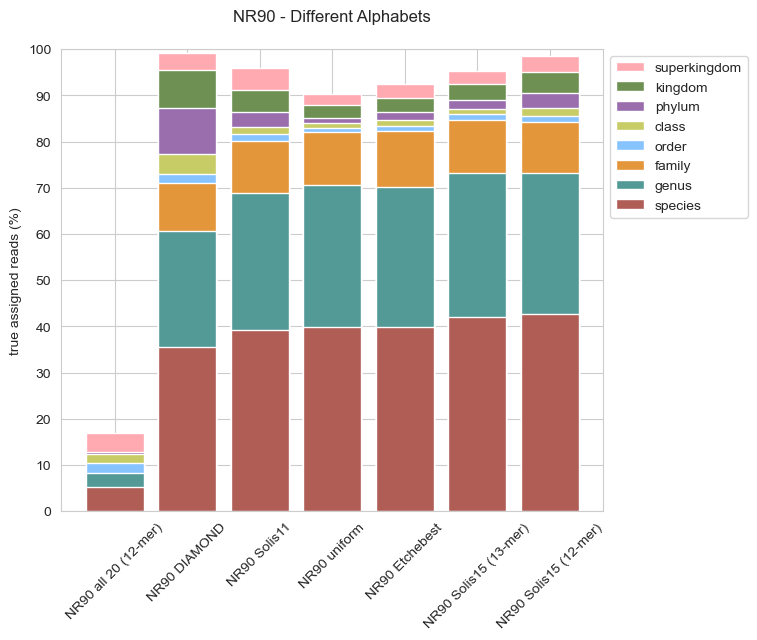

In [11]:
def plot_true_assigned_per_rank(df: pd.DataFrame, title: str = "", ranks: int = 8):
    ranks = ["superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"][:ranks]
    colors = ["#ffa9b1", "#6e9053", "#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
    colors = colors[len(colors)-len(ranks):]
    selection = select_alphabets_nr90
    data = pd.concat([df for df, name in ovo1_and_names], axis=1)[selection] / 1160526 * 100
    plt.figure(figsize=(len(selection),6))
    for rank, color in zip(ranks, colors):
        plt.bar(data.columns, data.loc[rank].values, label=rank, color=color, width=0.8)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.ylim(0, 100)
    plt.yticks(np.arange(0, 101, 10))
    plt.xticks(rotation=45)
    plt.ylabel("true assigned reads (%)")
    plt.title(title, pad=20)
    plt.show()

,NR90 Solis15 (13-mer),"NR90 Solis15 (13-mer, l=15)","NR90 Solis15 (13-mer, probability, l=15)","NR90 Solis15 (13-mer, probability, l=17)","NR90 Solis15 (13-mer, probability, l=20)","NR90 Solis15 (13-mer, probability, l=27)","NR90 Solis15 (13-mer, complexity, l=14)","NR90 Solis15 (13-mer, complexity, l=15)","NR90 Solis15 (13-mer, complexity, l=17)","NR90 Solis15 (13-mer, complexity, l=20)"
rank,,,,,,,,,,
superkingdom,95.381835,92.910111,92.778275,90.977884,88.605942,82.523183,93.140869,91.595966,89.207135,86.023665
phylum,89.108129,86.722055,87.022953,85.274350,82.967982,76.505223,87.299466,85.863134,83.417778,80.038362
class,87.101883,84.991375,85.431089,83.823714,81.561809,75.112234,85.601184,84.291606,81.945256,78.612371
order,85.929828,83.788989,84.312114,82.691986,80.390616,73.838501,84.450327,83.110331,80.722276,77.293400
family,84.724858,82.545587,83.140490,81.515537,79.149368,72.541330,83.247424,81.897174,79.491541,75.992352
kingdom,92.574488,89.991435,90.085186,88.209829,85.725869,79.210806,90.410986,88.842128,86.299057,82.873111
genus,73.114260,70.850718,71.425629,69.809207,67.412363,60.981314,71.616146,70.171629,67.642862,64.200457
species,42.033009,40.195997,40.647172,39.395929,37.521951,33.056648,40.773149,39.620827,37.683602,35.163107
Index Size (GB),269.000000,135.000000,169.000000,133.000000,106.000000,75.000000,163.000000,122.000000,85.000000,60.000000


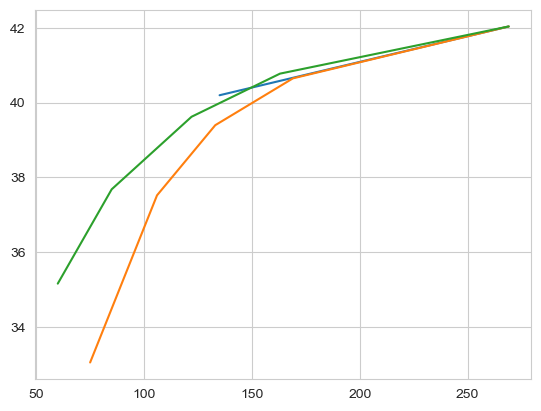

In [47]:
data = pd.concat([df for df, name in ovo1_and_names], axis=1)[selection] / 1160526 * 100
data.loc["Index Size (GB)"] = [269, 135, 169, 133, 106, 75, 163, 122, 85, 60]
plt.plot(data.loc["Index Size (GB)"][[0, 1]], data.loc["species"][[0, 1]].values)
plt.plot(data.loc["Index Size (GB)"][[0, 2, 3, 4, 5]], data.loc["species"][[0, 2, 3, 4, 5]].values)
plt.plot(data.loc["Index Size (GB)"][[0, 6, 7, 8, 9]], data.loc["species"][[0, 6, 7, 8, 9]].values)
data

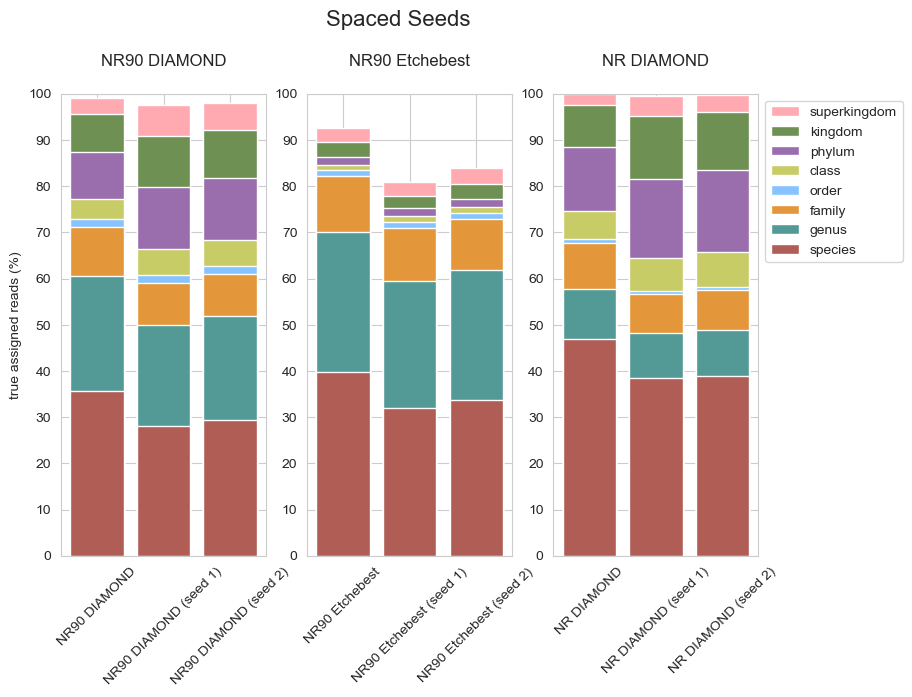

In [59]:
ranks = ["superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"]
colors = ["#ffa9b1", "#6e9053", "#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
colors = colors[len(colors)-len(ranks):]
selections = [select_spaced_seeds_nr90_diamond, select_spaced_seeds_nr90_etchebest, select_spaced_seeds_nr_diamond]
data = [pd.concat([df for df, name in ovo1_and_names], axis=1)[selection] / 1160526 * 100 for selection in selections]
fig, axes = plt.subplots(1, len(selections), figsize=(sum([len(x) for x in selections]), 6))
for i in range(len(selections)):
    for rank, color in zip(ranks, colors):
        axes[i].bar(data[i].columns, data[i].loc[rank].values, label=rank, color=color, width=0.8)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_title(selections[i][0], pad=20)
        plt.setp(axes[i], ylim=(0, 100), yticks=np.arange(0, 101, 10))
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
axes[0].set_ylabel("true assigned reads (%)")
fig.suptitle("Spaced Seeds", fontsize=16, y=1.02)
plt.show()

In [50]:
pd.concat([df for df, name in ovo1_and_names], axis=1)

,NR kraken2 protein,NR90 DIAMOND,NR90 DIAMOND (11111101101100111000100001),NR90 DIAMOND (11110010101011001101111),NR90 uniform,NR90 uniform (11111101101100111000100001),NR90 Etchebest,NR90 Etchebest filtered (p<1e-11),NR90 Etchebest filtered (p<1e-12),NR90 Etchebest filtered (p<1e-13),...,NR90 DIAMOND filtered (p<1e-10),NR90 DIAMOND filtered (p<1e-11),"NR90 DIAMOND filtered (p<1e-11, k>3)",NR90 DIAMOND filtered (p<1e-12),NR90 DIAMOND filtered (p<1e-13),NR DIAMOND,NR DIAMOND (11111101101100111000100001),NR DIAMOND (11110010101011001101111),NR DIAMOND filtered (p<1e-12),NR DIAMOND filtered (p<1e-11)
rank,,,,,,,,,,,,,,,,,,,,,
superkingdom,1135020,1152977,1131146,1137688,1047380,923743,1073243,1073243,1066293,1058161,...,1149788,1137639,1137648,1075713,920989,1159378,1155014,1157647,1155323,1155323
phylum,1075198,1031552,925704,949794,988497,866831,1002198,1002196,995142,991322,...,1011005,977877,978129,922240,812606,1025530,947404,968371,1000570,1000570
class,1047614,874257,769816,793532,975283,852970,981781,981779,975491,973474,...,897055,898064,898455,871179,781014,866265,747031,763076,889998,889998
order,1029714,778191,700500,722475,957112,834425,962301,962300,955771,953984,...,842264,862605,863009,844739,757601,795376,665373,676138,846367,846367
family,1026844,760576,685759,708275,951986,827397,953923,953922,947628,946042,...,827247,849067,849407,831739,744912,786111,656350,666776,838537,838537
kingdom,952270,735400,718871,731696,897622,777542,909668,909667,903714,900214,...,828510,865563,865549,840880,730212,713756,608610,609847,798142,798142
genus,949631,649917,579049,602263,819248,701251,814328,814327,807930,806183,...,705173,719612,719859,694997,614485,668883,558823,566183,708133,708133
species,745913,380637,325211,341019,462552,378971,462050,462049,458012,456954,...,413706,420056,420102,402407,356730,543596,446301,451339,572982,572982


In [33]:
tree = Tree("F:/Studium/Master/semester5/thesis/data/NCBI/taxdmp/tree_nr.txt")
true_taxons = get_true_taxons_for_all_ranks(tree, species)
test_assignment = read_per_taxon_assignment("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_kraken2_nr_processed/per_taxon_assignments.tsv", kmer_threshold=1000)

In [9]:
test_assignment

NameError: name 'test_assignment' is not defined

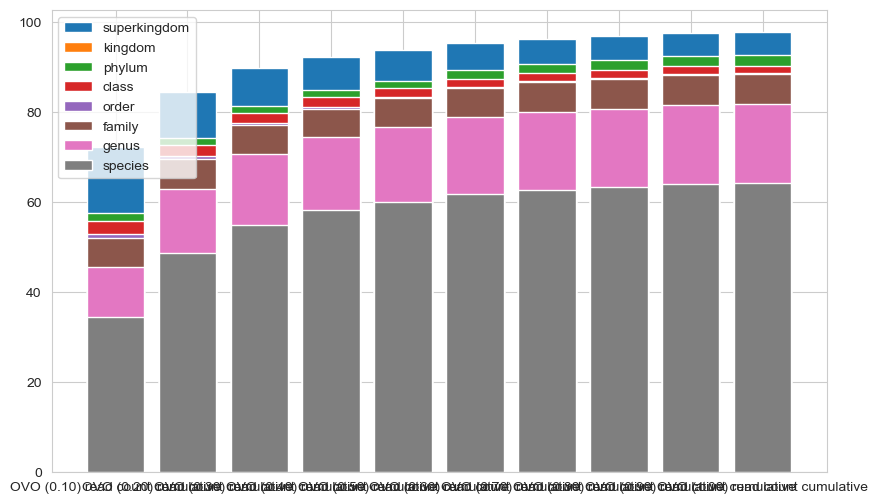

In [37]:
def calculate_true_positives_per_rank(per_taxon_assignment: pd.DataFrame, true_taxons: dict):
    true_positives = {}

df = test_assignment.loc[[label for labels in true_taxons.values() for label in labels if label in test_assignment.index]].groupby("rank").sum().drop([x for x in test_assignment.columns if x in ["kmer count",
                                                                                  "node id",
                                                                                  "label",
                                                                                  "kmers in database",
                                                                                  "kmer count (accumulated)",
                                                                                  "normalized kmer count"]], axis=1)
df = df.loc[:,[x for x in df.columns if x.endswith("read count cumulative") and x.startswith("OVO")]] / 1160526 * 100
#print([x for x in df.columns if x.endswith("cumulative") or x.endswith("(accumulated)")])

ranks = ["superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"]
plt.figure(figsize=(10,6))
for rank in ranks:
    plt.bar(df.columns, df.loc[rank].values, label=rank)
plt.legend()
df
plt.show()

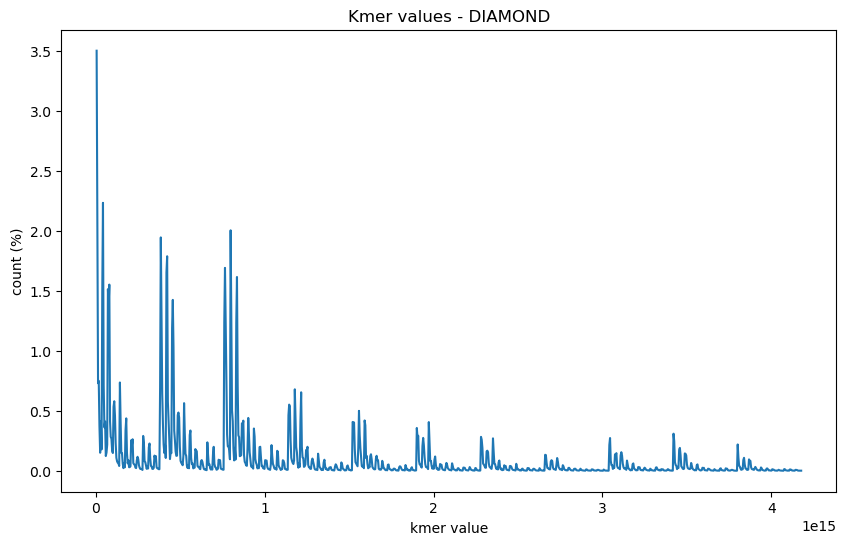

In [44]:
folder, title = "F:/Studium/Master/semester5/thesis/data/NCBI/nr90/index_diamond/statistics/", "Kmer values - DIAMOND"
#folder, title = "F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\nr90\\index_etchebest\\statistics\\", "Kmer values - Etchbest et al."

kmer_histograms = []
for index, file in enumerate([x for x in os.listdir(folder) if x.endswith("kmer_histogram.tsv")]):
    if index == 0: kmer_histograms.append(pd.read_csv(folder + file, sep="\t", header=0, names=["bucket", file.split("_")[0]]))
    else:  kmer_histograms.append(pd.read_csv(folder + file, sep="\t", header=0, usecols=[1], names=[file.split("_")[0]]))

kmer_histogram = pd.concat(kmer_histograms, axis=1)
kmer_histogram["sum"] = kmer_histogram.iloc[:, 1:].sum(axis=1)
total_kmers = kmer_histogram["sum"].sum()
kmer_histogram["sum (%)"] = kmer_histogram["sum"] / total_kmers * 100
kmer_histogram

plt.figure(figsize=(10,6))
plt.plot(kmer_histogram["bucket"], kmer_histogram["sum (%)"])
plt.xlabel("kmer value")
plt.ylabel("count (%)")
plt.title(title)
plt.show()

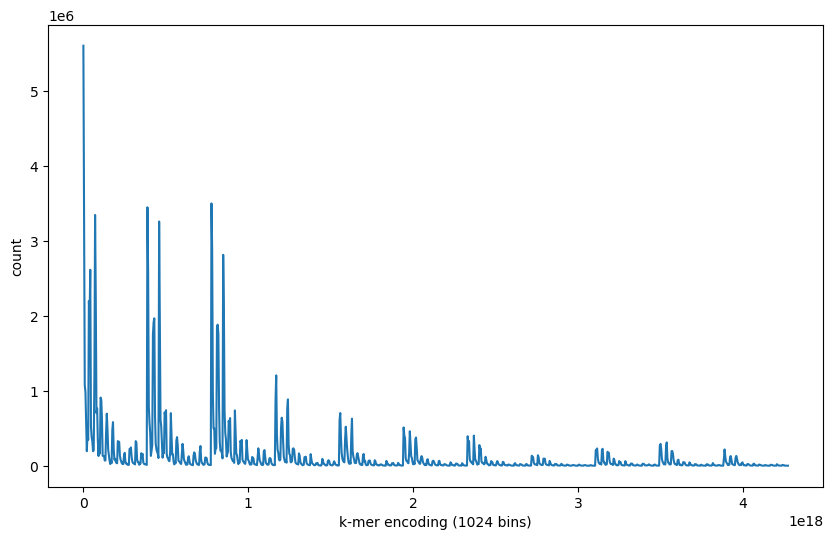

In [5]:
x = table.iloc[:,0]

plt.figure(figsize=(10,6))

# for column in table.columns[2:]:
#     plt.plot(x, table[column], label=column)

plt.plot(x, table["total"])
plt.xlabel("k-mer encoding (1024 bins)")
plt.ylabel("count")

# plt.legend()
plt.show()

In [25]:
base11_counts_zymo = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_zymo.txt", sep=": ", header=None, names=["number", "count"])
# _2 = base11_counts_zymo["count"][1]
# base11_counts_zymo["count"][1] = base11_counts_zymo["count"][2]
# base11_counts_zymo["count"][2] = _2
# _7 = base11_counts_zymo["count"][9]
# base11_counts_zymo["count"][9] = base11_counts_zymo["count"][7]
# base11_counts_zymo["count"][7] = _7

zymno_mean = sum([i * base11_counts_zymo["count"][i] for i in range(len(base11_counts_zymo))]) / sum(base11_counts_zymo["count"])
base11_counts_zymo

C:\Users\nk035\AppData\Local\Temp\ipykernel_14568\175288690.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  base11_counts_zymo = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_zymo.txt", sep=": ", header=None, names=["number", "count"])


,number,count
0,0,2920776439
1,1,1949437811
2,2,1830637054
3,3,514142039
4,4,513910784
5,5,450586530
6,6,249058792
7,7,275900774
8,8,262467223
9,9,150546931


In [26]:
base11_counts_nr100 = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_nr100.txt", sep=": ", header=None, names=["number", "count"])

# _2 = base11_counts_nr100["count"][1]
# base11_counts_nr100["count"][1] = base11_counts_nr100["count"][2]
# base11_counts_nr100["count"][2] = _2
# _7 = base11_counts_nr100["count"][9]
# base11_counts_nr100["count"][9] = base11_counts_nr100["count"][7]
# base11_counts_nr100["count"][7] = _7

nr100_mean = sum([i * base11_counts_nr100["count"][i] for i in range(len(base11_counts_nr100))]) / sum(base11_counts_nr100["count"])
base11_counts_nr100

C:\Users\nk035\AppData\Local\Temp\ipykernel_14568\516717748.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  base11_counts_nr100 = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_nr100.txt", sep=": ", header=None, names=["number", "count"])


,number,count
0,0,930399377
1,1,672806877
2,2,694816412
3,3,229603860
4,4,150393486
5,5,120829094
6,6,93554083
7,7,39872716
8,8,66460621
9,9,70456903


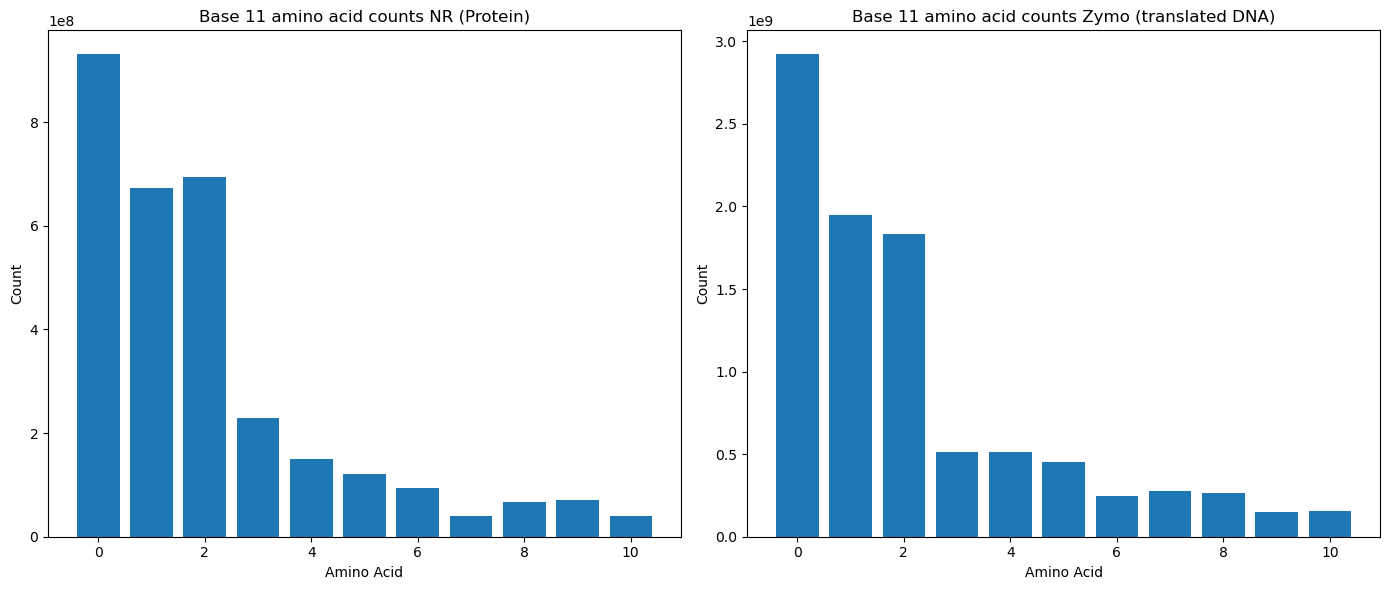

In [33]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(base11_counts_zymo["number"], base11_counts_zymo["count"])
#ax1.axvline(zymno_mean, color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel("Amino Acid")
ax1.set_ylabel("Count")
ax1.set_title("Base 11 amino acid counts Zymo (translated DNA)")

# Plot the second bar plot
ax2.bar(base11_counts_nr100["number"], base11_counts_nr100["count"])
#ax2.axvline(nr100_mean, color='r', linestyle='dashed', linewidth=1)
ax2.set_xlabel("Amino Acid")
ax2.set_ylabel("Count")
ax2.set_title("Base 11 amino acid counts NR (Protein)")

# Display the figure
plt.tight_layout()
plt.show()

In [86]:
rows = []

with open("F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\kmer_occurrences_longspaced.txt") as f:
    for line in f:
        values = line.split("\t")
        entries = {int(key): int(value) for key, value in [entry.split(":") for entry in values[2:]]}
        entries["bucket"] = values[0].split(" ")[1]
        entries["average"] = float(values[1])
        rows.append(entries)

# sort the columns
occ_ls = pd.DataFrame(rows)
occ_ls = occ_ls.reindex(["bucket", "average"] + sorted(occ_ls.columns.drop(["bucket", "average"])), axis=1)

# calculate row sums and convert to percentages
row_sums = occ_ls.iloc[:, 2:].sum(axis=1)
occ_ls.iloc[:, 2:] = occ_ls.iloc[:, 2:].div(row_sums, axis=0) * 100
occ_ls['sum'] = row_sums
occ_ls = occ_ls.reindex(["bucket", "average", "sum"] + sorted(occ_ls.columns.drop(["bucket", "average", "sum"])), axis=1)

occ_ls

C:\Users\nk035\AppData\Local\Temp\ipykernel_11672\3722694197.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occ_ls['sum'] = row_sums


,bucket,average,sum,1,2,3,4,5,6,7,...,3509314,3510650,3511356,3513133,3517585,3519056,3556295,9853585,10893928,396220181
0,0,11.935786,56620203.0,61.562139,15.388578,6.603268,3.742071,2.378944,1.656455,1.212161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002
1,1,4.984880,56615643.0,61.555374,15.387495,6.600234,3.748264,2.382446,1.660997,1.211195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
2,2,5.228943,56623402.0,61.556595,15.387311,6.597737,3.744598,2.381794,1.659386,1.212666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN
3,3,5.271318,56620125.0,61.549993,15.391792,6.598290,3.745728,2.381000,1.659060,1.213959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.042588,56628592.0,61.556026,15.389595,6.600212,3.744363,2.380909,1.657331,1.214358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,5.033649,56632988.0,61.541427,15.395207,6.602560,3.749287,2.379790,1.660409,1.212076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,100,5.195021,56608549.0,61.552685,15.382035,6.606550,3.748047,2.381958,1.660788,1.212421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,101,5.140609,56617011.0,61.553191,15.393026,6.598024,3.748163,2.376812,1.658018,1.212738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,102,4.811862,56610754.0,61.546455,15.388786,6.604492,3.747781,2.382164,1.658388,1.210169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


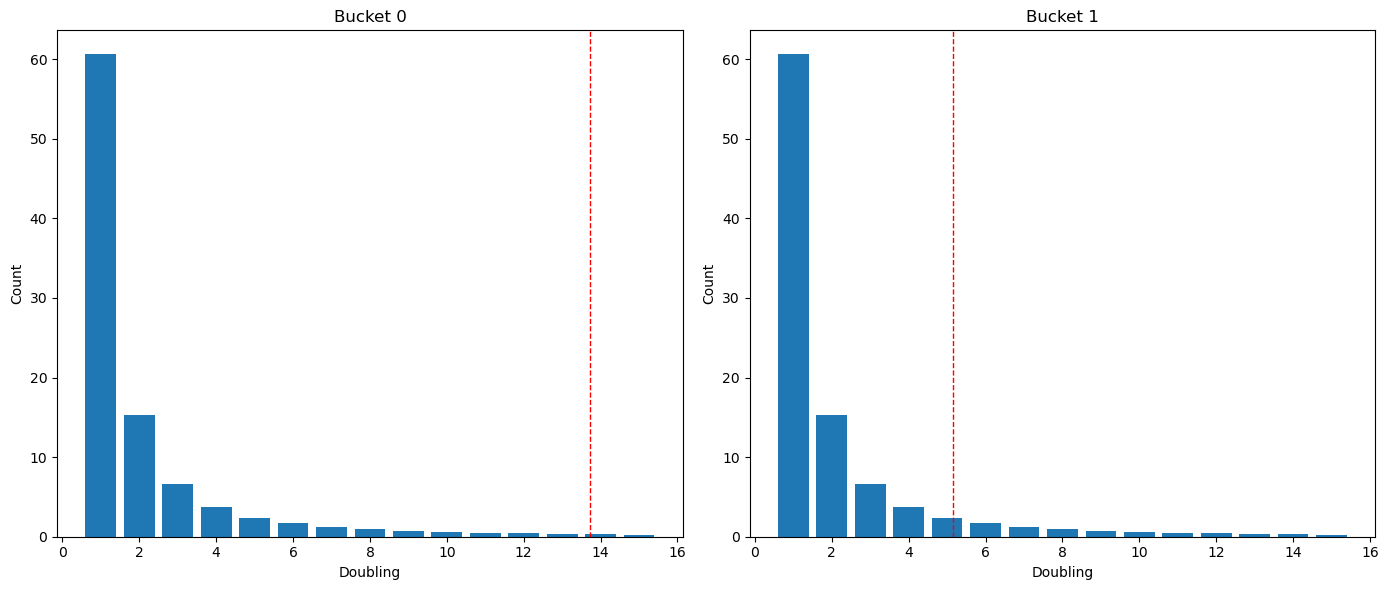

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[0].drop(["bucket", "average", "sum"])[:15])
ax1.axvline(occ_ls.iloc[0]["average"], color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel("Doubling")
ax1.set_ylabel("Count")
ax1.set_title("Bucket 0")

# Plot the second bar plot
ax2.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[1].drop(["bucket", "average", "sum"])[:15])
ax2.axvline(occ_ls.iloc[1]["average"], color='r', linestyle='dashed', linewidth=1)
ax2.set_xlabel("Doubling")
ax2.set_ylabel("Count")
ax2.set_title("Bucket 1")

# Display the figure
plt.tight_layout()
plt.show()

In [87]:
rows = []

with open("F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\kmer_occurrences_no_mask.txt") as f:
    for line in f:
        values = line.split("\t")
        entries = {int(key): int(value) for key, value in [entry.split(":") for entry in values[2:]]}
        entries["bucket"] = values[0].split(" ")[1]
        entries["average"] = float(values[1])
        rows.append(entries)

# sort the columns
occ = pd.DataFrame(rows)
occ = occ.reindex(["bucket", "average"] + sorted(occ.columns.drop(["bucket", "average"])), axis=1)

# calculate row sums and convert to percentages
row_sums = occ_ls.iloc[:, 2:].sum(axis=1)
occ.iloc[:, 2:] = occ.iloc[:, 2:].div(row_sums, axis=0) * 100
occ['sum'] = row_sums
occ = occ.reindex(["bucket", "average", "sum"] + sorted(occ.columns.drop(["bucket", "average", "sum"])), axis=1)

occ

C:\Users\nk035\AppData\Local\Temp\ipykernel_11672\3912453283.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occ['sum'] = row_sums


,bucket,average,sum,1,2,3,4,5,6,7,...,3489842,3489927,3494317,3498621,3504883,3507749,3511327,3667978,3773432,472874882
0,0,13.715886,56620303.0,60.586347,15.260210,6.574280,3.743823,2.384947,1.663711,1.222277,...,NaN,0.000002,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,0.000002
1,1,5.141871,56615743.0,60.597740,15.268243,6.570655,3.746320,2.384570,1.668179,1.220678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
2,2,5.254500,56623502.0,60.586426,15.260402,6.575277,3.742232,2.384513,1.666845,1.220643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN
3,3,5.557075,56620225.0,60.582329,15.264152,6.571535,3.743918,2.382550,1.663125,1.222090,...,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.299953,56628692.0,60.573410,15.257903,6.576908,3.748411,2.380828,1.666551,1.221245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5.284738,56624966.0,60.582509,15.261683,6.566280,3.740080,2.383650,1.669446,1.217555,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN
6,6,5.341595,56634795.0,60.572800,15.256893,6.572534,3.747532,2.387103,1.666603,1.218242,...,0.000002,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,5.585336,56611893.0,60.618642,15.261599,6.564859,3.744423,2.385071,1.665510,1.218984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,5.220836,56615005.0,60.589932,15.259506,6.573944,3.750649,2.385059,1.668249,1.220337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,5.516894,56625094.0,60.586047,15.266288,6.581617,3.746336,2.381299,1.666572,1.219087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


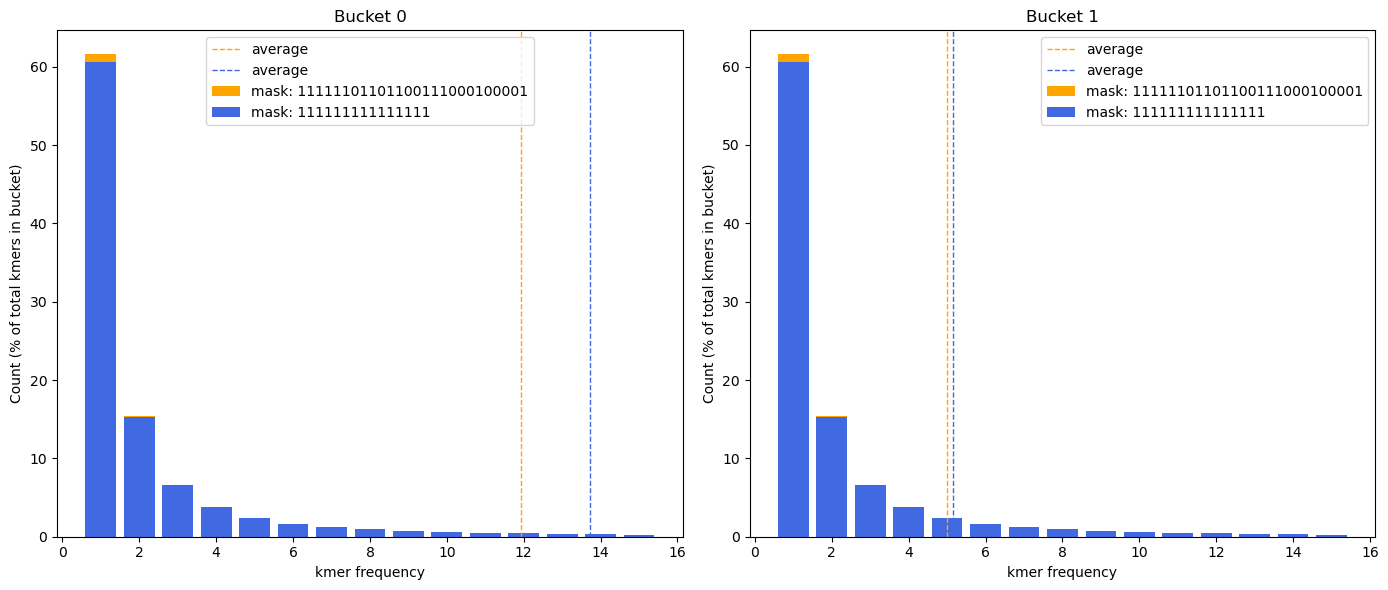

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[0].drop(["bucket", "average", "sum"])[:15], label='mask: 11111101101100111000100001', color="orange")
ax1.bar(occ.columns.drop(["bucket", "average", "sum"])[:15], occ.iloc[0].drop(["bucket", "average", "sum"])[:15], label="mask: 111111111111111", color="royalblue")
ax1.axvline(occ_ls.iloc[0]["average"], color='orange', linestyle='dashed', linewidth=1, label="average")
ax1.axvline(occ.iloc[0]["average"], color='royalblue', linestyle='dashed', linewidth=1, label="average")
ax1.set_xlabel("kmer frequency")
ax1.set_ylabel("Count (% of total kmers in bucket)")
ax1.set_title("Bucket 0")
ax1.legend()

# Plot the second bar plot
ax2.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[1].drop(["bucket", "average", "sum"])[:15], label='mask: 11111101101100111000100001', color="orange")
ax2.bar(occ.columns.drop(["bucket", "average", "sum"])[:15], occ.iloc[1].drop(["bucket", "average", "sum"])[:15], label="mask: 111111111111111", color="royalblue")
ax2.axvline(occ_ls.iloc[1]["average"], color='orange', linestyle='dashed', linewidth=1, label="average")
ax2.axvline(occ.iloc[1]["average"], color='royalblue', linestyle='dashed', linewidth=1, label="average")
ax2.set_xlabel("kmer frequency")
ax2.set_ylabel("Count (% of total kmers in bucket)")
ax2.set_title("Bucket 1")
ax2.legend()

# Display the figure
plt.tight_layout()
plt.show()

In [18]:
per_taxon = pd.read_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\test_dataset\\assignment_nr90_diamond_filteredByLikelihood\\per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon = per_taxon[per_taxon["kmer count"] >= 1000].sort_values(["kmer count"], ascending=False).reset_index(drop=True)
per_taxon

,node id,rank,label,kmers in database,kmer count,kmer count (accumulated),OVO (0.10) read count,OVO (0.10) read count cumulative,OVO (0.10) read count (norm. kmers),OVO (0.10) read count (norm. kmers) cumulative,...,OVA (0.80) read count (norm. kmers) cumulative,OVA (0.90) read count,OVA (0.90) read count cumulative,OVA (0.90) read count (norm. kmers),OVA (0.90) read count (norm. kmers) cumulative,OVA (1.00) read count,OVA (1.00) read count cumulative,OVA (1.00) read count (norm. kmers),OVA (1.00) read count (norm. kmers) cumulative,normalized kmer count
0,2,superkingdom,Bacteria,100717184,82509577,236289537,145986,792138,189184,826807,...,340103,127508,340103,127508,340103,127508,340103,127508,340103,0.819220
1,131567,no rank,cellular organisms,34831614,40298483,291431838,265298,1099079,206409,1090334,...,1009188,637154,1009188,637154,1009188,637154,1009188,637154,1009188,1.156951
2,1,no rank,root,37773646,26704066,318467561,5964,1105467,10626,1105467,...,1105467,95862,1105467,95862,1105467,95862,1105467,95862,1105467,0.706950
3,1236,class,Gammaproteobacteria,35676907,15111629,76557248,8247,85380,4320,99583,...,9620,1111,9620,1111,9620,1111,9620,1111,9620,0.423569
4,543,family,Enterobacteriaceae,20777249,14132683,44534541,25588,64463,13078,67842,...,4376,1135,4376,1135,4376,1135,4376,1135,4376,0.680200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6190,550683,strain,Escherichia coli B921,540,1000,1000,0,0,3,3,...,0,0,0,0,0,0,0,0,0,1.851852
6191,83428,species,uncultured Bacillus sp.,364455,1000,1000,5,5,5,5,...,3,3,3,3,3,3,3,3,3,0.002744
6192,3032205,species,Lentzea sp. NBRC 105346,1142956,1000,1000,6,6,5,5,...,4,4,4,4,4,4,4,4,4,0.000875
6193,1071,species,Rhodopila globiformis,924422,1000,1000,2,2,7,7,...,2,2,2,2,2,2,2,2,2,0.001082


In [3]:
#dfs_and_names = [(read_per_taxon_assignment(path), name) for path, name in paths_and_names]
true_assigned_reads_species_and_names = [(true_positives(read_per_taxon_assignment(path, "species"), 1160526, list(species), "species"), name) for path, name in paths_and_names]

In [4]:
#true_assigned_reads_species_and_names = [(true_assigned_reads(df, species, "species"), name) for df, name in dfs_and_names]
# unify algorithm names
for df, name in true_assigned_reads_species_and_names:
    df.index = [x.replace("0000", "").replace("ratio: ", "").replace("(accumulated)", "cumulative") for x in df.index]

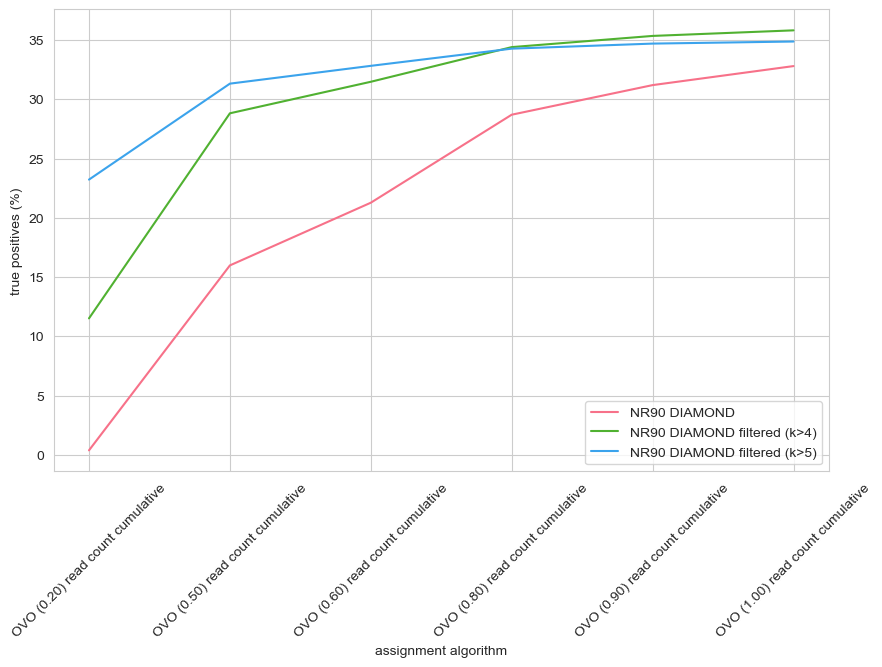

In [8]:
# true_assigned_reads_genera = true_assigned_reads(df, genera, "genus")
# # true_assigned_reads_df = pd.merge(true_assigned_reads_species, true_assigned_reads_genera, left_on="assignment algorithm", right_on="assignment algorithm")
# # true_assigned_reads_df
plt.figure(figsize=(10,6))
indices_filterings = [1, 7, 8, 9, 10, 11, 13, 14]
indices_masks_diamond = [1, 2, 3, 16, 17, 18]
indices_alphabets = [1, 3, 5]
indices_diamond_filtering = [15, 18, 19]
indices_etchebest_filtering = [6, 8, 9]
indices_complexity_filtering = [1, 8, 9, 11, 12]
indices = indices_complexity_filtering
colors = sns.color_palette("husl", len(indices))
for i, index in enumerate(indices):
    df, name = true_assigned_reads_species_and_names[index]
    color = colors[i]
    plt.plot(df.loc[[
        "OVO (0.20) read count cumulative",
        "OVO (0.50) read count cumulative",
        "OVO (0.60) read count cumulative",
        "OVO (0.80) read count cumulative",
        "OVO (0.90) read count cumulative",
        "OVO (1.00) read count cumulative"],"true assigned reads (%)"], label=name, color=color)
plt.xticks(rotation=45)
plt.xlabel("assignment algorithm")
plt.ylabel("true positives (%)")
plt.legend()
plt.show()

In [11]:
per_taxon = pd.read_csv("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filtered_5/per_taxon_assignments.tsv", header=0, sep="\t")

In [12]:
species = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}
species_ids = {
    "Pseudomonas aeruginosa": 287,
    "Escherichia coli": 562,
    "Salmonella enterica": 28901,
    "Staphylococcus aureus": 1280,
    "Limosilactobacillus fermentum": 1613,
    "Enterococcus faecalis": 1351,
    "Listeria monocytogenes": 1639,
    "Bacillus subtilis": 1423,
    "Saccharomyces cerevisiae": 4932,
    "Cryptococcus neoformans": 5207
}
genera = {
    "Pseudomonas",
    "Escherichia",
    "Salmonella",
    "Staphylococcus",
    "Limosilactobacillus",
    "Enterococcus",
    "Listeria",
    "Bacillus",
    "Saccharomyces",
    "Cryptococcus"}

level = "species"
min_colum_index = 3
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Listeria monocytogenes,Enterococcus faecalis,Escherichia coli,Pseudomonas aeruginosa,Bacillus subtilis,Staphylococcus aureus,Limosilactobacillus fermentum,Cryptococcus neoformans,Saccharomyces cerevisiae,Salmonella enterica,sum
kmers in database,7387.0,2126.0,105.0,477.0,5712.0,3799.0,10919.0,6964.0,5986.0,1046.0,44521.0
kmer count,7.0,5.0,0.0,1.0,11.0,3.0,2.0,16.0,12.0,6.0,63.0
kmer count (accumulated),7.0,5.0,1.0,2.0,12.0,4.0,3.0,10.0,13.0,0.0,57.0
OVO (0.10) read count,3.0,2.0,6.0,4.0,9.0,1.0,0.0,16.0,7.0,8.0,56.0
OVO (0.10) read count cumulative,3.0,4.0,6.0,5.0,9.0,2.0,0.0,10.0,8.0,1.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...
OVA (1.00) read count,15.0,4.0,7.0,20.0,105.0,1.0,0.0,55.0,243.0,12.0,462.0
OVA (1.00) read count cumulative,11.0,4.0,6.0,18.0,50.0,1.0,0.0,15.0,163.0,2.0,270.0
OVA (1.00) read count (norm. kmers),15.0,4.0,7.0,20.0,105.0,1.0,0.0,55.0,243.0,12.0,462.0
OVA (1.00) read count (norm. kmers) cumulative,11.0,4.0,6.0,18.0,50.0,1.0,0.0,15.0,163.0,2.0,270.0


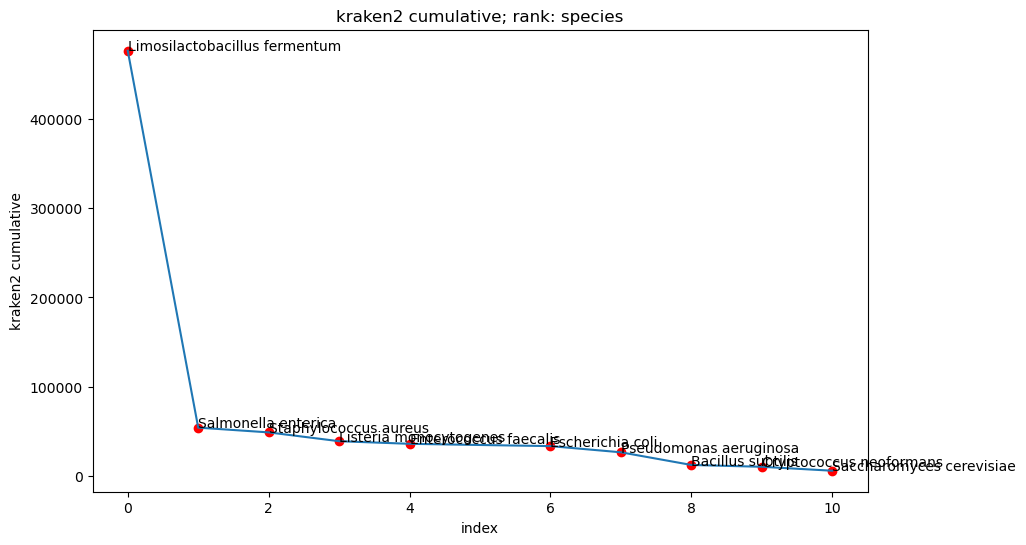

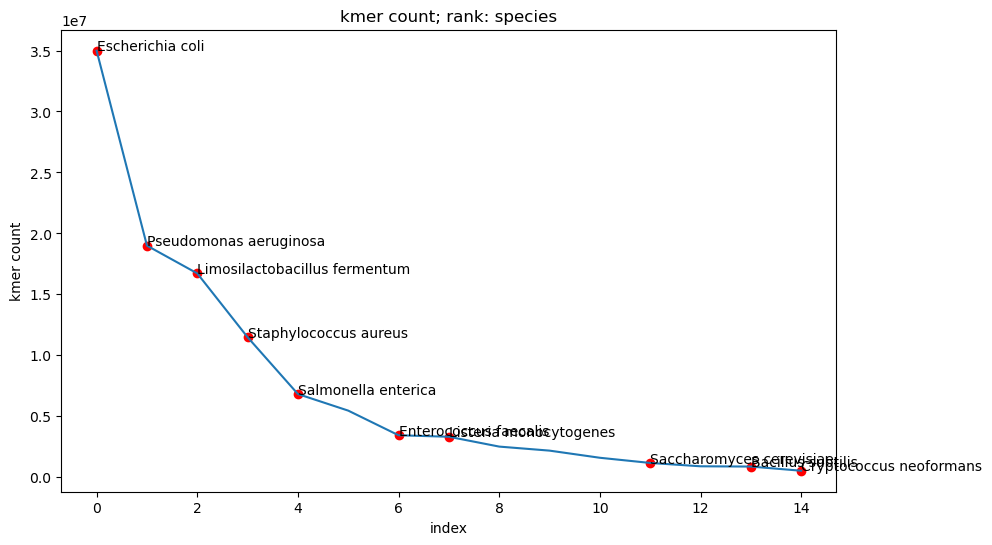

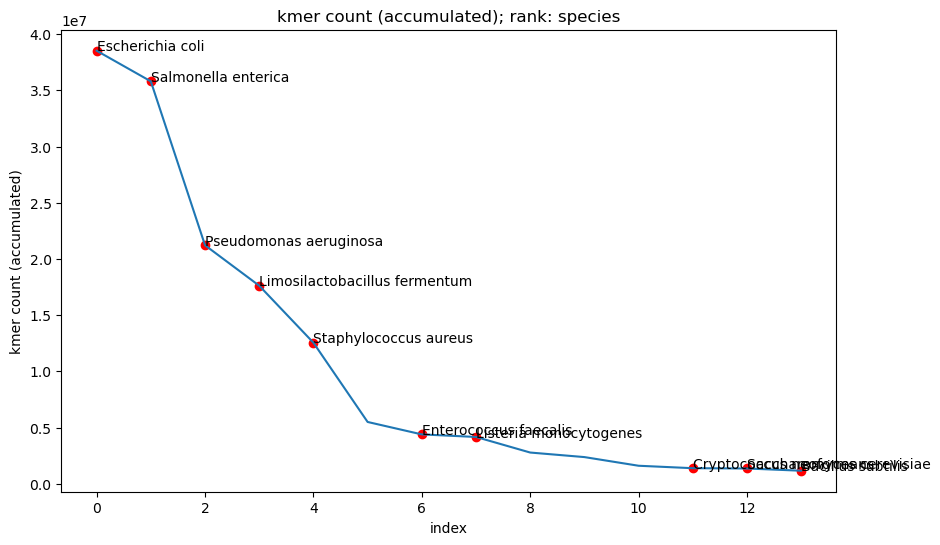

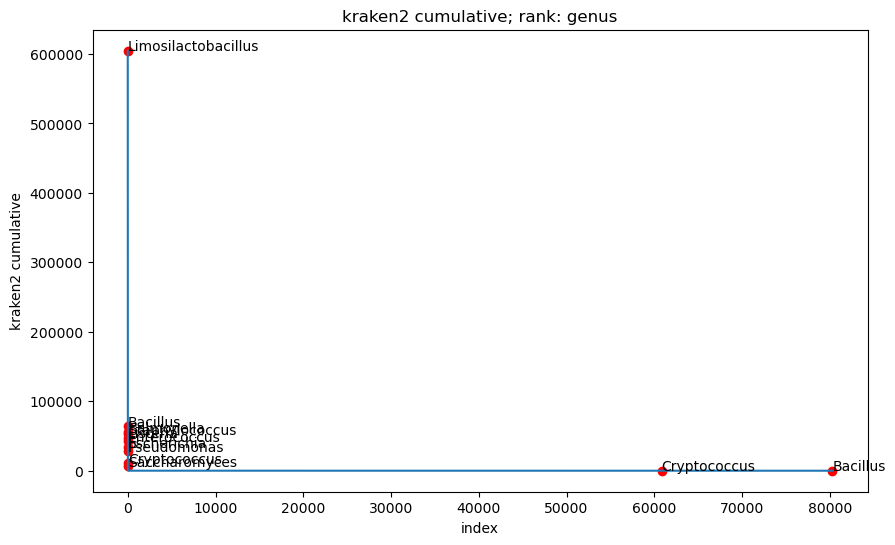

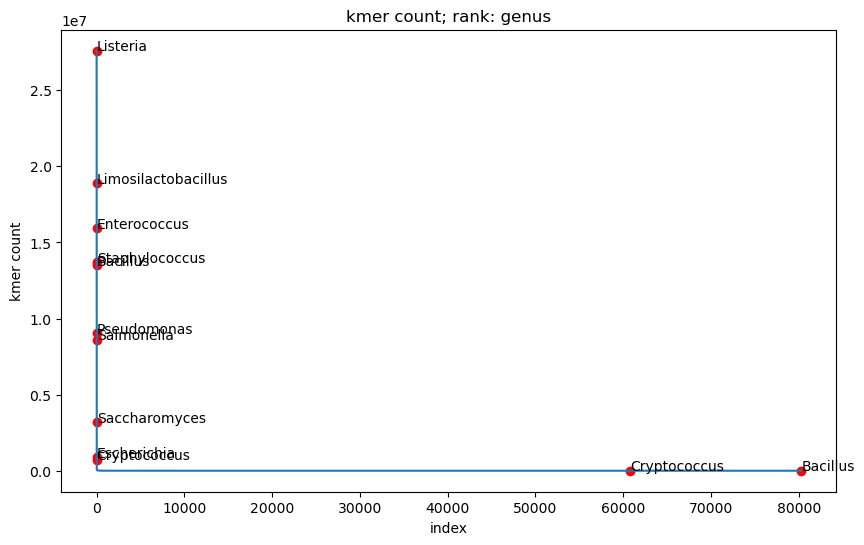

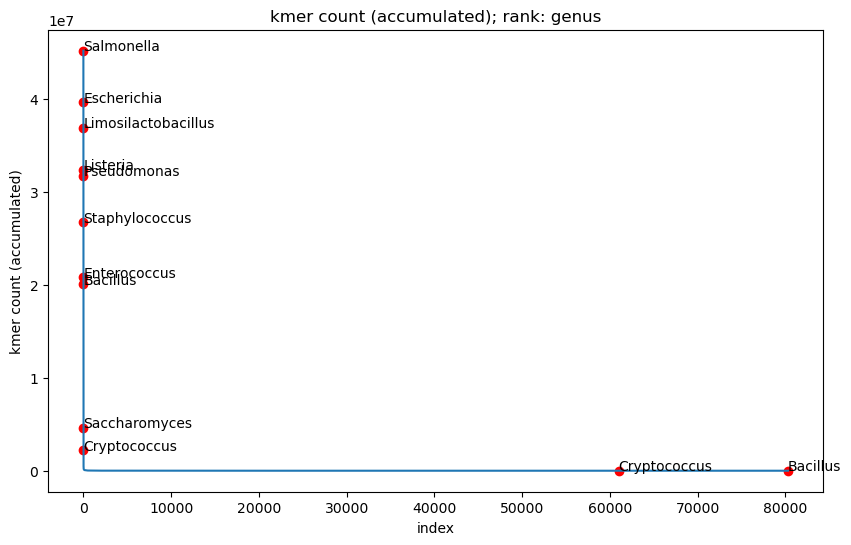

In [7]:
def generate_plot_of_values(data, value, rank, labels):
    data_ = data[["label", value]].loc[(per_taxon["rank"] == rank)].sort_values(value, ascending=False).reset_index(drop=True)
    only_labels = data_[data_["label"].isin(labels)]
    max_index = only_labels.index.max() + 1
    plt.figure(figsize=(10,6))
    plt.title(value + "; rank: " + rank)
    plt.plot(data_[value][:max_index])
    plt.xlabel("index")
    plt.ylabel(value)
    plt.scatter(only_labels.index, only_labels[value], color="red")
    for i, row in only_labels.iterrows():
        plt.annotate(row["label"], (i, row[value]))
    plt.show()

for column in per_taxon.columns[4:]:
    generate_plot_of_values(per_taxon, column, "species", species)

for column in per_taxon.columns[4:]:
    generate_plot_of_values(per_taxon, column, "genus", genera)

In [15]:
per_taxon = pd.read_csv("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_kraken2_nr_processed/per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon = per_taxon[(per_taxon['rank'] == "species") & (per_taxon["kmer count"] >= 1000)].sort_values(["kmer count"], ascending=False).reset_index(drop=True)
per_taxon

,node id,rank,label,kmer count,kmer count (accumulated),kraken2,kraken2 cumulative,OVO (0.20) read count,OVO (0.20) read count cumulative,OVO (0.50) read count,OVO (0.50) read count cumulative,OVO (0.60) read count,OVO (0.60) read count cumulative,OVO (0.80) read count,OVO (0.80) read count cumulative,OVO (0.90) read count,OVO (0.90) read count cumulative,OVO (1.00) read count,OVO (1.00) read count cumulative
0,562,species,Escherichia coli,34984626,38521178,6833,33706,14862,16768,22610,31197,19962,32147,13772,33156,9758,33499,6829,33673
1,287,species,Pseudomonas aeruginosa,18997747,21216028,5493,26776,17035,21431,14340,25557,12377,25989,8758,26468,6877,26641,5476,26734
2,1613,species,Limosilactobacillus fermentum,16720341,17618521,412613,475959,327379,372215,393382,449550,402527,461243,409970,471626,413224,476180,413595,477040
3,1280,species,Staphylococcus aureus,11484948,12548442,21312,49049,30305,38282,31350,45872,29305,47087,25115,48342,22518,48848,21316,49017
4,28901,species,Salmonella enterica,6824691,35797279,1223,54371,1979,44232,1537,51749,1431,52815,1339,53972,1267,54415,1235,54593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12519,2058314,species,Flavobacterium sp. ALD4,1000,1000,1,1,0,0,0,0,0,0,0,0,1,1,1,1
12520,2817775,species,Mycoplana sp. BE70,1000,1000,0,0,1,1,1,1,1,1,1,1,1,1,1,1
12521,79879,species,Evansella clarkii,1000,1000,1,1,0,0,0,0,0,0,2,2,2,2,2,2
12522,2849652,species,Duganella violaceipulchra,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
level = "species"
min_colum_index = 3
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Salmonella enterica,Enterococcus faecalis,Staphylococcus aureus,Bacillus subtilis,Cryptococcus neoformans,Listeria monocytogenes,Saccharomyces cerevisiae,Limosilactobacillus fermentum,Escherichia coli,Pseudomonas aeruginosa,sum
kmer count,4.0,6.0,3.0,13.0,14.0,7.0,11.0,2.0,0.0,1.0,61.0
kmer count (accumulated),1.0,6.0,4.0,13.0,11.0,7.0,12.0,3.0,0.0,2.0,59.0
kraken2,11.0,4.0,2.0,6.0,18.0,3.0,10.0,0.0,5.0,7.0,66.0
kraken2 cumulative,1.0,4.0,2.0,8.0,9.0,3.0,10.0,0.0,6.0,7.0,50.0
OVO (0.20) read count,9.0,2.0,1.0,8.0,12.0,3.0,7.0,0.0,5.0,4.0,51.0
OVO (0.20) read count cumulative,1.0,3.0,2.0,10.0,8.0,4.0,9.0,0.0,6.0,5.0,48.0
OVO (0.50) read count,11.0,3.0,1.0,7.0,12.0,4.0,8.0,0.0,2.0,6.0,54.0
OVO (0.50) read count cumulative,1.0,4.0,2.0,9.0,8.0,3.0,10.0,0.0,5.0,6.0,48.0
OVO (0.60) read count,11.0,4.0,1.0,7.0,13.0,5.0,9.0,0.0,2.0,6.0,58.0
OVO (0.60) read count cumulative,1.0,4.0,2.0,9.0,8.0,3.0,10.0,0.0,5.0,7.0,49.0


In [8]:
per_taxon = pd.read_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\test_dataset\\assignment_nr_ncbi_longspaced\\per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon[per_taxon['rank'] == "species"].sort_values(["kmer count"], ascending=False).reset_index(drop=True)

,node id,rank,label,kmers in database,kmer count,kmer count (accumulated),OVO (0.20) read count,OVO (0.20) read count cumulative,OVO (0.20) read count (norm. kmers),OVO (0.20) read count (norm. kmers) cumulative,...,OVA (0.80) read count (norm. kmers) cumulative,OVA (0.90) read count,OVA (0.90) read count cumulative,OVA (0.90) read count (norm. kmers),OVA (0.90) read count (norm. kmers) cumulative,OVA (1.00) read count,OVA (1.00) read count cumulative,OVA (1.00) read count (norm. kmers),OVA (1.00) read count (norm. kmers) cumulative,normalized kmer count
0,287,species,Pseudomonas aeruginosa,18215662,12921717,14439466,4220,5452,5030,9918,...,4,4,4,4,4,4,4,4,4,0.709374
1,562,species,Escherichia coli,40381490,12663844,13714272,7728,9196,10413,16840,...,4,3,4,3,4,3,4,3,4,0.313605
2,1280,species,Staphylococcus aureus,9337298,4167914,4419691,1331,1625,8147,20976,...,108,104,108,104,108,104,108,104,108,0.446373
3,28901,species,Salmonella enterica,22121878,4021667,13783632,1026,24945,543,28238,...,12,7,12,7,12,7,12,7,12,0.181796
4,1613,species,Limosilactobacillus fermentum,861803,3747835,4029077,23602,26742,12927,42382,...,242,219,242,219,242,219,242,219,242,4.348830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160659,161627,species,Plectrophenax nivalis,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2160660,371921,species,Plectrophenax hyperboreus,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2160661,1002905,species,Ploceus sp. GGS-2011,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2160662,1002906,species,Quelea sp. GGS-2011,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [9]:
level = "species"
min_colum_index = 4
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Cryptococcus neoformans,Escherichia coli,Bacillus subtilis,Listeria monocytogenes,Staphylococcus aureus,Enterococcus faecalis,Limosilactobacillus fermentum,Salmonella enterica,Pseudomonas aeruginosa,Saccharomyces cerevisiae,sum
kmer count,86.0,1.0,57.0,9.0,2.0,18.0,4.0,3.0,0.0,47.0,227.0
kmer count (accumulated),30.0,2.0,43.0,6.0,3.0,17.0,4.0,1.0,0.0,40.0,146.0
OVO (0.20) read count,145.0,1.0,12.0,7.0,3.0,5.0,0.0,4.0,2.0,64.0,243.0
OVO (0.20) read count cumulative,49.0,2.0,12.0,7.0,4.0,5.0,0.0,1.0,3.0,47.0,130.0
OVO (0.20) read count (norm. kmers),101.0,1.0,9.0,5.0,2.0,3.0,0.0,6.0,4.0,12.0,143.0
...,...,...,...,...,...,...,...,...,...,...,...
OVA (1.00) read count,741784.0,112.0,1066.0,40.0,1.0,60.0,0.0,35.0,77.0,730059.0,1473234.0
OVA (1.00) read count cumulative,741794.0,70.0,187.0,27.0,1.0,60.0,0.0,16.0,81.0,730071.0,1472307.0
OVA (1.00) read count (norm. kmers),741784.0,112.0,1066.0,40.0,1.0,60.0,0.0,35.0,77.0,730059.0,1473234.0
OVA (1.00) read count (norm. kmers) cumulative,741794.0,70.0,187.0,27.0,1.0,60.0,0.0,16.0,81.0,730071.0,1472307.0


In [2]:
per_taxon = pd.read_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\test_dataset\\assignment_nr_ncbi_zhang\\per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon[per_taxon['rank'] == "species"].sort_values(["kmer count"], ascending=False).reset_index(drop=True)

,node id,rank,label,kmers in database,kmer count,kmer count (accumulated),OVO (0.20) read count,OVO (0.20) read count cumulative,OVO (0.20) read count (norm. kmers),OVO (0.20) read count (norm. kmers) cumulative,...,OVA (0.80) read count (norm. kmers) cumulative,OVA (0.90) read count,OVA (0.90) read count cumulative,OVA (0.90) read count (norm. kmers),OVA (0.90) read count (norm. kmers) cumulative,OVA (1.00) read count,OVA (1.00) read count cumulative,OVA (1.00) read count (norm. kmers),OVA (1.00) read count (norm. kmers) cumulative,normalized kmer count
0,562,species,Escherichia coli,41789935,14127688,15369707,7651,8980,10969,17464,...,0,0,0,0,0,0,0,0,0,0.338064
1,287,species,Pseudomonas aeruginosa,18627557,13963145,15637973,4526,5804,5406,10279,...,2,2,2,2,2,2,2,2,2,0.749596
2,1280,species,Staphylococcus aureus,9559285,4421808,4736959,987,1226,8337,21155,...,45,43,45,43,45,43,45,43,45,0.462567
3,1613,species,Limosilactobacillus fermentum,880208,4243900,4569490,20410,23261,11361,42274,...,61,50,61,50,61,50,61,50,61,4.821474
4,28901,species,Salmonella enterica,22579016,4161874,15549294,973,24833,508,28950,...,9,2,9,2,9,2,9,2,9,0.184325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174484,1497527,species,Emberiza socotrana,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2174485,1402987,species,Emberiza goslingi,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2174486,12375,species,Lactococcus phage (ISOLATE 7-9),22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2174487,12374,species,Lactococcus phage,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [4]:
per_taxon[per_taxon['rank'] == "species"].sort_values(["kmer count"], ascending=False).reset_index(drop=True)
level = "species"
min_colum_index = 4
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(
        drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Salmonella enterica,Saccharomyces cerevisiae,Staphylococcus aureus,Escherichia coli,Pseudomonas aeruginosa,Bacillus subtilis,Enterococcus faecalis,Limosilactobacillus fermentum,Listeria monocytogenes,Cryptococcus neoformans,sum
kmer count,4.0,47.0,2.0,0.0,1.0,64.0,21.0,3.0,11.0,85.0,238.0
kmer count (accumulated),1.0,40.0,3.0,2.0,0.0,48.0,16.0,4.0,6.0,30.0,150.0
OVO (0.20) read count,4.0,63.0,3.0,1.0,2.0,12.0,6.0,0.0,7.0,151.0,249.0
OVO (0.20) read count cumulative,0.0,47.0,4.0,2.0,3.0,12.0,5.0,1.0,7.0,30.0,111.0
OVO (0.20) read count (norm. kmers),6.0,13.0,2.0,1.0,3.0,8.0,4.0,0.0,5.0,125.0,167.0
...,...,...,...,...,...,...,...,...,...,...,...
OVA (1.00) read count,80.0,735575.0,1.0,217412.0,56.0,299706.0,88.0,0.0,86.0,747381.0,2000385.0
OVA (1.00) read count cumulative,13.0,735581.0,1.0,217420.0,69.0,299714.0,67.0,0.0,71.0,215.0,1253151.0
OVA (1.00) read count (norm. kmers),80.0,735575.0,1.0,217412.0,56.0,299706.0,88.0,0.0,86.0,747381.0,2000385.0
OVA (1.00) read count (norm. kmers) cumulative,13.0,735581.0,1.0,217420.0,69.0,299714.0,67.0,0.0,71.0,215.0,1253151.0
